# IFT870 - Forage de données - TP1

Membres de l'équipe :
- Joë Larue
- Aurélien Vauthier

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# setup notebook parameters
%matplotlib inline
%load_ext autoreload
%autoreload 2

# extract data
data = pd.read_csv("TP1_data.csv", index_col=0)

# compute some global stats
dataNoClass = data.drop("classe", axis=1)
classMasks = [data["classe"] == classId for classId in range(3)]
classCentroids = [np.mean(dataNoClass[classMask], axis=0) for classMask in classMasks]
classCov = [dataNoClass[classMask].cov() for classMask in classMasks]

print("Affichons un aperçu des premières observations :")
data.head()

Affichons un aperçu des premières observations :


,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


## 1. Représentation des données

Nous allons commencer par étudier les relations entre les variables pour déterminer s'il est nécessaire d’appliquer une transformation
des variables basée sur l’analyse des composantes principales (ACP).

Commençons par un pairplot :

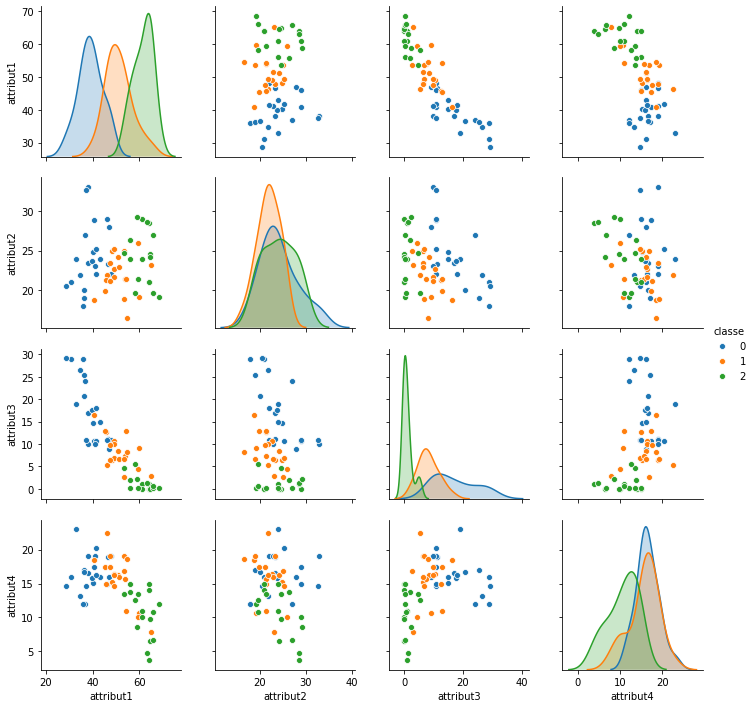

In [2]:
sns.pairplot(data, hue="classe", diag_kind="kde", vars=dataNoClass.columns)

# TODO...

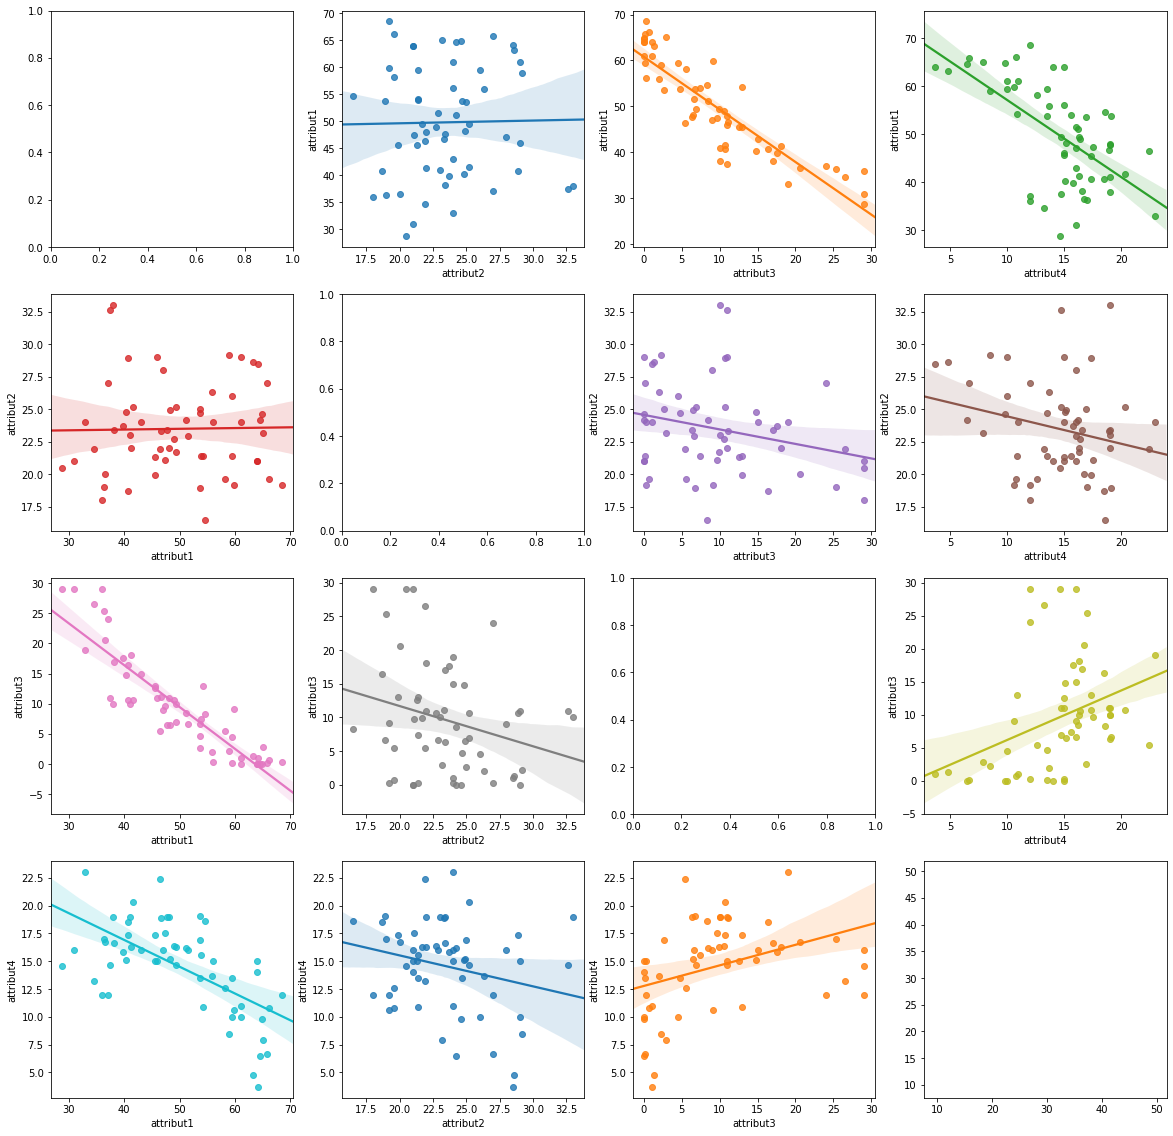

In [3]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))

for i, x in enumerate(dataNoClass.columns):
    for j, y in enumerate(dataNoClass.columns):
        if x == y:
            continue
            
        # TODO: pour chaque classe afficher les trois couples d'attributs plutôt que toutes les paires d'attributs
        sns.regplot(y, x, data, ax=axes[i,j])

fig.show()

# TODO...

Résultats des distances moyennes entre une observation et son centroïde pour les données originelles:
   - Classe 0 : 8.8444
   - Classe 1 : 6.7551
   - Classe 2 : 6.1644
Résultats des distances moyennes entre une observation et son centroïde pour l'ACP à 2CP:
   - Classe 0 : 8.1996
   - Classe 1 : 5.9723
   - Classe 2 : 4.2522
Résultats des distances moyennes entre une observation et son centroïde pour l'ACP à 3CP:
   - Classe 0 : 8.7566
   - Classe 1 : 6.6937
   - Classe 2 : 6.1002


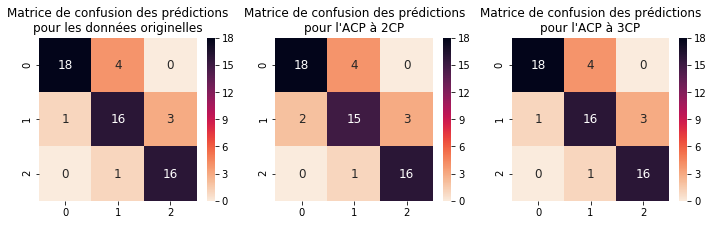

In [4]:
from sklearn.decomposition import PCA
from scipy.linalg import norm

pca2 = PCA(n_components=2)
pca3 = PCA(n_components=3)
pcaName = {
    pca2 : "l'ACP à 2CP",
    pca3 : "l'ACP à 3CP",
    None : "les données originelles"
}

fig, axes = plt.subplots(1,3, figsize=(12,3))
    
for pcaIndex, pca in enumerate([None, pca2, pca3]):
    transformedData = dataNoClass.values if pca is None else pca.fit_transform(dataNoClass)
    sumDistances = np.zeros(3)
    predictionConfusionMatrix = np.zeros((3,3), dtype=int)
    
    transformedDataCentroids = [np.mean(transformedData[classMask], axis=0) for classMask in classMasks]
    
    for i, x in enumerate(transformedData):
        dataClass = data["classe"][i]
        sumDistances[dataClass] += norm( transformedDataCentroids[dataClass] - x )
        prediction = np.argmin(norm(transformedDataCentroids - x, axis=1))
        predictionConfusionMatrix[dataClass, prediction] += 1
        
    _, classCounts = np.unique(data["classe"], return_counts=True)
    sumDistances /= classCounts
    
    print(f"Résultats des distances moyennes entre une observation et son centroïde pour {pcaName[pca]}:")
    for i, meanDist in enumerate(sumDistances):
        print(f"   - Classe {i} : {meanDist:.4f}")
    sns.heatmap(predictionConfusionMatrix, annot=True, fmt="d", cmap=sns.cm.rocket_r, ax=axes[pcaIndex], annot_kws={"fontsize":12}).set_title(f"Matrice de confusion des prédictions\npour {pcaName[pca]}")

fig.show()

## 2. Mesure de distance

D’après les résultats sur l’analyse de corrélation entre les variables de représentation (1.(a)),
quelle mesure de distance (Manhattan, Euclidienne, ou Mahalanobis) entre les objets serait la plus
adéquate ? Vérifiez votre réponse en calculant pour chacune des mesures de distance, le centroïde
le plus proche de chaque objet, puis en comparant avec les classes réelles des objets.

Résultats des distances moyennes entre une observation et son centroïde pour Manhattan:
   - Classe 0 : 15.0905
   - Classe 1 : 11.7220
   - Classe 2 : 10.3723
Résultats des distances moyennes entre une observation et son centroïde pour Euclidienne:
   - Classe 0 : 8.8444
   - Classe 1 : 6.7551
   - Classe 2 : 6.1644
Résultats des distances moyennes entre une observation et son centroïde pour Mahalanobis (covariance globale):
   - Classe 0 : 87.9754
   - Classe 1 : 65.0627
   - Classe 2 : 50.9847
Résultats des distances moyennes entre une observation et son centroïde pour Mahalanobis (covariance par classe):
   - Classe 0 : 66.9126
   - Classe 1 : 36.1967
   - Classe 2 : 26.9376


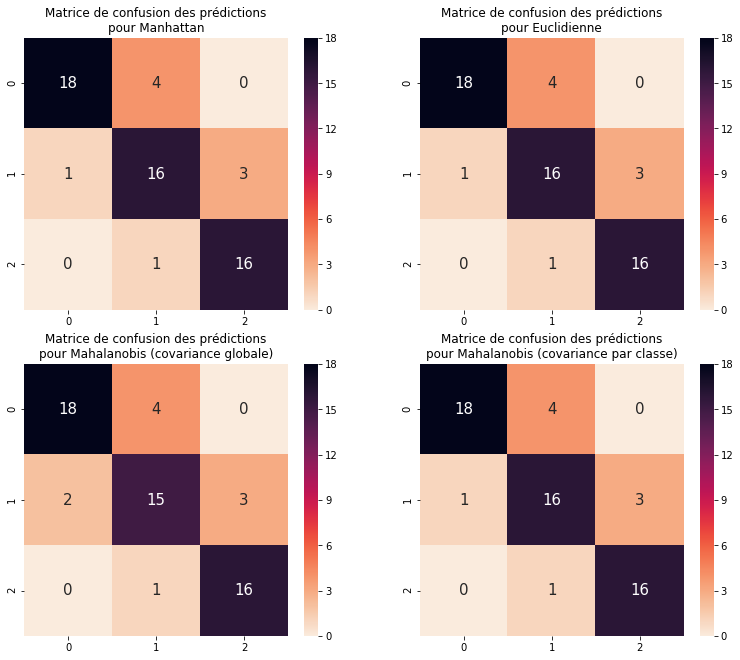

In [7]:
from scipy.spatial.distance import cityblock, euclidean, mahalanobis

fig, axes = plt.subplots(2, 2, figsize=(13,11))

# create the same interface for all distances
distances = [
    lambda x, y, _: cityblock(x, y),
    lambda x, y, _: euclidean(x, y),
    lambda x, y, _: mahalanobis(x, y, dataNoClass.cov()),
    lambda x, y, classId: mahalanobis(x, y, classCov[classId])
]
distName = {
    distances[0] : "Manhattan",
    distances[1] : "Euclidienne",
    distances[2] : "Mahalanobis (covariance globale)",
    distances[3] : "Mahalanobis (covariance par classe)"
}

for distIndex, distance in enumerate(distances):
    sumDistances = np.zeros(3)
    predictionConfusionMatrix = np.zeros((3,3), dtype=int)
    
    for i, x in enumerate(dataNoClass.values):
        dataClass = data["classe"][i]
        sumDistances[dataClass] += distance(classCentroids[dataClass], x, dataClass)
        prediction = np.argmin([distance(centroid, x, centroidClass) for centroidClass, centroid in enumerate(classCentroids)])
        predictionConfusionMatrix[dataClass, prediction] += 1
        
    _, classCounts = np.unique(data["classe"], return_counts=True)
    sumDistances /= classCounts
    
    print(f"Résultats des distances moyennes entre une observation et son centroïde pour {distName[distance]}:")
    for i, meanDist in enumerate(sumDistances):
        print(f"   - Classe {i} : {meanDist:.4f}")
    sns.heatmap(predictionConfusionMatrix, annot=True, fmt="d", cmap=sns.cm.rocket_r, ax=axes[distIndex//2, distIndex%2], annot_kws={"fontsize":15}).set_title(f"Matrice de confusion des prédictions\npour {distName[distance]}")

fig.show()

Pour la distance de Mahalanobis, on peut utiliser une matrice de covariance par classe ou une
matrice de covariance pour toutes les données. Laquelle des deux options est la plus adéquate ?

Comme on peut le voir sur les deux dernière matrices de confusion,
il est préférable d'utiliser une matrice de covariance par classe.

## 3. Choix du modèle de classification

En utilisant la meilleure représentation des données retenue au Point 1, et la meilleure
mesure de distance retenue au Point 2, tester la méthode des k = 5 plus proches voisins
ou la méthode du plus proche centroïde, et déterminez la plus adéquate.

On fait l’hypothèse que les objets correspondent à des mélanges de distributions gaussiennes
correspondant aux classes. Déterminez si cette hypothèse est vraissemblable en
appliquant une classification par modèle de mélange gaussien ("Gaussian Mixture Model”)
aux données. Justifiez votre choix parmi les quatre options du modèle pour la
covariance des différentes classes (spherical, diag, tied, ou full).

## 4. Application

À l’aide du modèle retenue au Point 3., déterminez la classe de la nouvelle
observation suivante : $[52.1, 23.0, 6.1, 16.5]$

In [6]:
x = [52.1, 23.0, 6.1, 16.5]

